In [1]:
import pathlib

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import tqdm

from dataset_fetcher import download_uci_adult
from real_games import multi_shapley_values

%matplotlib inline

In [2]:
sns.set_style()

In [3]:
# load data and fit model
data_dir = pathlib.Path('adult_dataset')
train_df, test_df = download_uci_adult(data_dir)

selected_features = ['relationship', 'capitalgain', 'education-num', 'marital-status', 'age']

x_train = train_df[selected_features]
x_test = test_df[selected_features]
y_train = train_df['class']
y_test = test_df['class']

model = lgb.LGBMClassifier().fit(x_train, y_train)
model_fn = lambda x: model.predict_proba(x)[:, 1]

In [4]:
class DataFrameMapper:
    """Maps a dataframe bidirectionally between df and numpy array.
    
    Necessary to run SHAP with categorical features.
    """
    def __init__(self, df):
        self.df = df

        # for each categorical variable, create a map between a numerical
        # code and the name of that category
        self.cat_codes_map = {}
        for col in self.df.select_dtypes('category'):
            self.cat_codes_map[col] = dict(enumerate(df[col].cat.categories))

    @staticmethod
    def convert_to_ndarray(df):
        # avoid modifying the df in-place
        df = df.copy()

        # encode categoricals as integers
        for c in df.select_dtypes('category'):
            df[c] = df[c].cat.codes

        # encode booleans as integers
        for c in df.select_dtypes('bool'):
            df[c] = df[c].astype('uint8')

        return df.values

    def df_from_ndarray(self, ndarray):
        result_df = pd.DataFrame(ndarray, columns=self.df.columns)
        for col in self.df:
            if col in self.cat_codes_map:
                result_df[col] = (result_df[col]
                                  .apply(self.cat_codes_map[col].get)
                                  .astype(self.df.dtypes[col]))
            else:
                result_df[col] = result_df[col].astype(self.df.dtypes[col])
        return result_df

# Verify lemma 1: equivalence

In [5]:
model_input = x_test.iloc[0:1]

_, phi = multi_shapley_values(model_fn, model_input, x_test)

mapper = DataFrameMapper(x_test)
mapped_model_fn = lambda x: model_fn(mapper.df_from_ndarray(x))
exp = shap.KernelExplainer(mapped_model_fn, mapper.convert_to_ndarray(x_test))
phi_shap = exp.shap_values(mapper.convert_to_ndarray(model_input), l1_reg=False)[0]

print('Via SHAP:')
print(phi_shap)
print('Via averaging games:')
print(phi.mean().values)

pre-computing payout functions...


100%|██████████| 16281/16281 [00:01<00:00, 11286.52it/s]


computing shapley values...


100%|██████████| 16281/16281 [00:12<00:00, 1294.25it/s]
Using 16281 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|██████████| 1/1 [00:02<00:00,  2.18s/it]

Via SHAP:
[-0.04101397 -0.03335699 -0.05314692 -0.05783287 -0.04838853]
Via averaging games:
[-0.04101397 -0.03335699 -0.05314692 -0.05783287 -0.04838853]


# CI and bootstrapping
Let's imagine that we only have access to 500 counterfactual evaluations, rather than 16k. We will consider the mean of the full 16k as "ground truth" and examine how confidence intervals from a Gaussian assumption and from bootstrapping can be used to understand the uncertainty of our smaller 500-point sample.

In [6]:
phi_mean_ground_truth = phi.mean()

pre-computing payout functions...


100%|██████████| 500/500 [00:00<00:00, 47621.42it/s]


computing shapley values...


  3%|▎         | 273/10000 [00:00<00:03, 2722.02it/s]

bootstrapping CI


100%|██████████| 10000/10000 [00:03<00:00, 2744.75it/s]


pre-computing payout functions...


100%|██████████| 500/500 [00:00<00:00, 41425.22it/s]


computing shapley values...


  3%|▎         | 253/10000 [00:00<00:03, 2521.52it/s]

bootstrapping CI


100%|██████████| 10000/10000 [00:03<00:00, 2694.06it/s]


pre-computing payout functions...


100%|██████████| 500/500 [00:00<00:00, 8112.33it/s]


computing shapley values...


  2%|▏         | 249/10000 [00:00<00:03, 2483.11it/s]

bootstrapping CI


100%|██████████| 10000/10000 [00:03<00:00, 2766.47it/s]


pre-computing payout functions...


100%|██████████| 500/500 [00:00<00:00, 56936.77it/s]


computing shapley values...


  3%|▎         | 270/10000 [00:00<00:03, 2695.57it/s]

bootstrapping CI


100%|██████████| 10000/10000 [00:03<00:00, 2758.78it/s]


pre-computing payout functions...


100%|██████████| 500/500 [00:00<00:00, 70272.83it/s]


computing shapley values...


  3%|▎         | 258/10000 [00:00<00:03, 2577.53it/s]

bootstrapping CI


100%|██████████| 10000/10000 [00:03<00:00, 2721.32it/s]


pre-computing payout functions...


100%|██████████| 500/500 [00:00<00:00, 65307.42it/s]


computing shapley values...


  5%|▌         | 516/10000 [00:00<00:03, 2477.12it/s]

bootstrapping CI


100%|██████████| 10000/10000 [00:03<00:00, 2724.13it/s]


pre-computing payout functions...


100%|██████████| 500/500 [00:00<00:00, 45006.16it/s]


computing shapley values...


  2%|▏         | 213/10000 [00:00<00:04, 2121.54it/s]

bootstrapping CI


100%|██████████| 10000/10000 [00:03<00:00, 2698.13it/s]


pre-computing payout functions...


100%|██████████| 500/500 [00:00<00:00, 58079.98it/s]


computing shapley values...


  2%|▏         | 238/10000 [00:00<00:04, 2372.70it/s]

bootstrapping CI


100%|██████████| 10000/10000 [00:03<00:00, 2690.12it/s]


pre-computing payout functions...


100%|██████████| 500/500 [00:00<00:00, 26450.80it/s]


computing shapley values...


  2%|▏         | 227/10000 [00:00<00:04, 2268.15it/s]

bootstrapping CI


100%|██████████| 10000/10000 [00:03<00:00, 2714.54it/s]


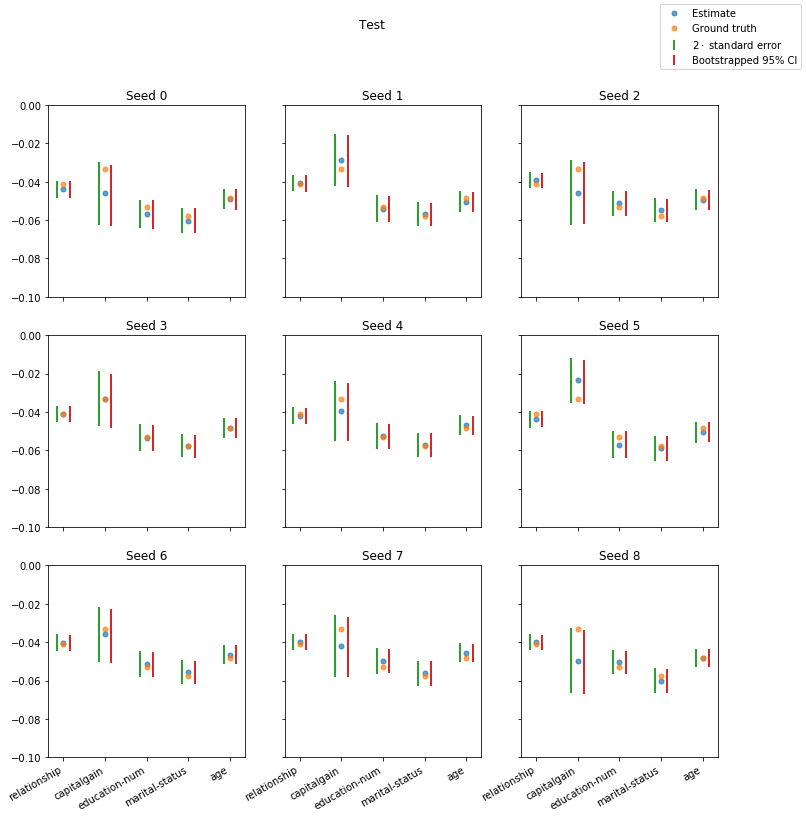

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
axes_iter = (axes[i // 3, i % 3] for i in range(9))
palette = sns.color_palette()
for seed, ax in enumerate(axes_iter):
    x_test_small = x_test.sample(500, random_state=seed)
    _, phi = multi_shapley_values(model_fn, model_input, x_test_small)
    mean_estimate = phi.mean()
    column_names = phi.columns
    x_pos = np.arange(len(mean_estimate))
    
    # bootstrap 95% CI
    print('bootstrapping CI')
    n_boot = 10_000
    rng = np.random.RandomState(seed)
    sampled_means = np.array([
        phi.sample(phi.shape[0], replace=True, random_state=rng).mean()
        for _ in tqdm.tqdm(range(n_boot))
    ])
    for col_id in range(sampled_means.shape[1]):
        sampled_means[:, col_id] = np.sort(sampled_means[:, col_id])
    ci_95 = np.array([mean_estimate - sampled_means[int(0.025 * n_boot), :], 
                      sampled_means[int(0.975 * n_boot), :]  - mean_estimate])
    
    # compute 2x standard error
    twice_stderr = 2 * phi.std() / np.sqrt(phi.shape[0])
    
    # plot everything
    ax.plot(x_pos, mean_estimate, marker='.', ms=10, lw=0, color=palette[0], label='Estimate', alpha=0.7)
    ax.plot(x_pos, phi_mean_ground_truth, marker='.', ms=10, lw=0, color=palette[1], label='Ground truth', alpha=0.7)
    ax.errorbar(x_pos - 0.15, mean_estimate, yerr=twice_stderr, ecolor=palette[2], elinewidth=2, lw=0, label='$2 \cdot$ standard error')
    ax.errorbar(x_pos + 0.15, mean_estimate, yerr=ci_95, ecolor=palette[3], elinewidth=2, lw=0, label='Bootstrapped 95% CI')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(column_names, rotation=30, ha='right')
    ax.set_title(f'Seed {seed}')
legend = fig.legend(*ax.get_legend_handles_labels(), loc='upper right')
fig.suptitle('Test')
plt.ylim(-0.1, 0)
plt.show()